In [ ]:
import sys
import numpy as np
import pickle
np.random.seed(0)
from scripts import (
    train_test_split,
    StandardScaler,
    accuracy,
    confusion_matrix,
    recall_per_class,
    balanced_accuracy,
    KernelPerceptron,
    SVM,
    rbf_kernel,
)
import matplotlib.pyplot as plt

import pandas as pd

In [ ]:

# --- Load training data ---
path_to_data = 'ift-3395-6390-kaggle-2-competition-fall-2025/train_data.pkl'
with open(path_to_data, "rb") as f:
    train_data = pickle.load(f)

# Convertir comme avant
X_imgs = train_data["images"].astype(np.float32)
y = train_data["labels"].reshape(-1)


class_count = np.bincount(y)
print("Class distribution in training set:", class_count)


X_train_imgs, X_val_imgs, y_train, y_val = train_test_split(
    X_imgs, y, test_size=0.2, random_state=0, stratify=y
)

train_min = X_train_imgs.min()
train_max = X_train_imgs.max()

train_mean = X_train_imgs.mean()
train_std = X_train_imgs.std()

X_train_imgs = (X_train_imgs - train_min) / (train_max - train_min + 1e-6)
X_train_imgs = (X_train_imgs - train_mean) / (train_std + 1e-6)

X_val_imgs = (X_val_imgs - train_min) / (train_max - train_min + 1e-6)
X_val_imgs = (X_val_imgs - train_mean) / (train_std + 1e-6)


Class distribution in training set: [486 128 206 194  66]


In [82]:
def radial_profile(img):
    """Calcule le profil radial moyen d'une image."""
    h, w = img.shape
    y, x = np.ogrid[:h, :w]
    r = np.sqrt((x - w//2)**2 + (y - h//2)**2).astype(int)
    profile = np.bincount(r.ravel(), img.ravel()) / np.bincount(r.ravel())
    return np.log(profile + 1e-6)


In [83]:
def extract_simple_stats(img):
    gray = img.mean(axis=2)
    return np.array([gray.mean(), gray.std(), gray.min(), gray.max()], dtype=np.float32)


In [84]:
def simple_augment(images, labels):
    flips = images[:, :, ::-1, :]  
    noise = images + 0.01*np.random.randn(*images.shape)
    aug_imgs = np.concatenate([images, flips, noise], axis=0)
    aug_labels = np.concatenate([labels, labels, labels])
    return aug_imgs, aug_labels


In [85]:
def extract_channel_stats(img):
    # img.shape est (H, W, 3)
    features = []
    for c in range(img.shape[2]): # Itere sur les 3 canaux
        channel = img[:, :, c]
        features.extend([channel.mean(), channel.std(), channel.min(), channel.max()])
    return np.array(features, dtype=np.float32)

In [86]:

def fft_features(images):
    """Extrait les caractéristiques FFT d'images."""
    gray = images.mean(axis=3)
    F = np.fft.fft2(gray, axes=(1, 2))
    return np.abs(np.fft.fftshift(F, axes=(1, 2)))



In [87]:
def convolve_2d_sobel(image, kernel):
    k_h, k_w = kernel.shape
    i_h, i_w = image.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    
    # Ajouter le padding (nécessaire pour Sobel)
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge') # edge padding souvent mieux pour Sobel
    output = np.zeros_like(image, dtype=np.float32)
    
    for i in range(i_h):
        for j in range(i_w):
            window = padded_image[i:i+k_h, j:j+k_w]
            output[i, j] = np.sum(window * kernel)
            
    return output

def extract_sobel_features(img):
    # Canal Vert (indice 1) est souvent le meilleur pour les vaisseaux
    green_channel = img[:, :, 1] 
    
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

    Ix = convolve_2d_sobel(green_channel, Gx)
    Iy = convolve_2d_sobel(green_channel, Gy)

    # Magnitude du gradient (approximation simple: |Ix| + |Iy|)
    # Utiliser np.sqrt(Ix**2 + Iy**2) est plus précis mais plus lent.
    magnitude = np.abs(Ix) + np.abs(Iy) 
    
    # Caractéristiques : Moyenne et écart-type de la magnitude
    return np.array([magnitude.mean(), magnitude.std()], dtype=np.float32)

In [88]:
def rgb_to_hsv(img):
    """Convertit une image RGB (0-1.0) en HSV (H:0-360, S:0-1, V:0-1)."""
    R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    
    # Valeur (V)
    V = np.max(img, axis=2)
    
    # Min de R, G, B
    M_min = np.min(img, axis=2)
    
    # Delta (pour éviter la division par zéro)
    Delta = V - M_min
    
    # Saturation (S)
    S = np.zeros_like(V)
    # Masque pour les pixels où Delta > 0 (nécessaire pour la division)
    mask = Delta > 1e-6 
    S[mask] = Delta[mask] / V[mask]
    
    # Teinte (H)
    H = np.zeros_like(V)
    
    # Préparation des masques spécifiques
    R_is_max = (R == V) & mask
    G_is_max = (G == V) & mask
    B_is_max = (B == V) & mask

    # Calcul de H pour chaque cas (utilisant la formule trigonométrique)
    H[R_is_max] = 60 * (G[R_is_max] - B[R_is_max]) / Delta[R_is_max]
    H[G_is_max] = 60 * (2.0 + (B[G_is_max] - R[G_is_max]) / Delta[G_is_max])
    H[B_is_max] = 60 * (4.0 + (R[B_is_max] - G[B_is_max]) / Delta[B_is_max])
    
    # Correction des valeurs négatives pour H (H doit être entre 0 et 360)
    H[H < 0] += 360
    
    # Empilement et retour (Normaliser H de 0-360 à 0-1.0 pour la cohérence)
    H_norm = H / 360.0
    
    return np.stack([H_norm, S, V], axis=2)

def extract_hsv_stats(img):
    hsv_img = rgb_to_hsv(img)
    features = []
    
    # Extraire les statistiques pour H (Teinte) et S (Saturation)
    for c in range(2): # 0=H, 1=S
        channel = hsv_img[:, :, c]
        features.extend([channel.mean(), channel.std()]) # Moyenne et écart-type sont les plus utiles
        
    return np.array(features, dtype=np.float32)

In [89]:
def extract_regional_stats(img):
    # Utiliser le canal vert (indice 1) pour le contraste
    green_channel = img[:, :, 1] 
    H, W = green_channel.shape
    H_half, W_half = H // 2, W // 2
    
    # Quadrants (Q1: top-left, Q2: top-right, etc.)
    Q1 = green_channel[:H_half, :W_half]
    Q2 = green_channel[:H_half, W_half:]
    Q3 = green_channel[H_half:, :W_half]
    Q4 = green_channel[H_half:, W_half:]
    
    features = []
    for Q in [Q1, Q2, Q3, Q4]:
        # Ajouter la moyenne et l'écart-type de chaque quadrant
        features.extend([Q.mean(), Q.std()])
        
    # Total : 4 quadrants * 2 stats = 8 caractéristiques
    return np.array(features, dtype=np.float32)

In [90]:
X_train_imgs, y_train = simple_augment(X_train_imgs, y_train)

In [91]:

# X_ff 
# Test accuracy = 0.35185185185185186
# Balanced acc : 0.21607963740224237

# X_stats
#Test accuracy = 0.21296296296296297
#Balanced acc : 0.21641103008968235

# X_color
#Test accuracy = 0.39351851851851855
#Balanced acc : 0.26298782099637014


# X_regional

# Test accuracy = 0.3611111111111111
# Balanced acc : 0.19380218306544683

# X_sobel
# Test accuracy = 0.3101851851851852
# Balanced acc : 0.19615481325312858

# X_hsv
# Test accuracy = 0.35648148148148145
# Balanced acc : 0.2990335454504426

fft_mag_train = fft_features(X_train_imgs)
X_fft_train = np.array([radial_profile(img) for img in fft_mag_train], dtype=np.float32)
X_stats_train = np.array([extract_simple_stats(img) for img in X_train_imgs], dtype=np.float32)
X_color_train = np.array([extract_channel_stats(img) for img in X_train_imgs], dtype=np.float32)

X_sobel_train = np.array([extract_sobel_features(img) for img in X_train_imgs], dtype=np.float32)
X_hsv_train = np.array([extract_hsv_stats(img) for img in X_train_imgs], dtype=np.float32)
X_regional_train = np.array([extract_regional_stats(img) for img in X_train_imgs], dtype=np.float32)



fft_mag_val = fft_features(X_val_imgs)
X_fft_val = np.array([radial_profile(img) for img in fft_mag_val], dtype=np.float32)
X_stats_val = np.array([extract_simple_stats(img) for img in X_val_imgs], dtype=np.float32)
X_color_val = np.array([extract_channel_stats(img) for img in X_val_imgs], dtype=np.float32)

X_sobel_val = np.array([extract_sobel_features(img) for img in X_val_imgs], dtype=np.float32)
X_hsv_val = np.array([extract_hsv_stats(img) for img in X_val_imgs], dtype=np.float32)
X_regional_val = np.array([extract_regional_stats(img) for img in X_val_imgs], dtype=np.float32)




In [92]:
X_train = np.hstack([
                     X_fft_train,
                     X_stats_train, 
                     X_color_train,
                     ])

X_val = np.hstack([
                   X_fft_val, 
                   X_stats_val, 
                   X_color_val,
                 ])

In [93]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [94]:
class_counts = np.bincount(y_val)
class_weights = (1.0 / class_counts)
class_weights /= class_weights.sum() 
sample_weights = class_weights[y_train]

In [95]:
model = KernelPerceptron(kernel_fn=rbf_kernel, n_classes=5, sigma=1, learning_rate=1.0,  sample_weights=None, lam=0.0)

model.fit(X_train, y_train, max_epochs=50)


Understanding Deep Learning Requires Rethinking Generalization
(Zhang et al., ICLR 2017) → importance de la fréquence dans image classification.
Fourier Transform in Image Processing — Gonzalez & Woods
(exemples de séparation de classes via magnitude spectrale)
FOURIER CNNs (Rippel et al., 2015)
→ montre qu'une représentation FFT est plus stable et expressive que pixels bruts.
Spectral Representations for Image Classification (several IEEE papers)
→ radial power spectra suffisent à classifier des textures complexes.
Why Do Deep Neural Networks Learn High-Frequency Patterns?
(Xu et al., NeurIPS 2019)

In [96]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=0)
svm_model.fit(X_train, y_train)
y_val_pred = svm_model.predict(X_val)


In [97]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Test accuracy = 0.4722222222222222
              precision    recall  f1-score   support

           0       0.64      0.69      0.66        97
           1       0.33      0.15      0.21        26
           2       0.35      0.37      0.36        41
           3       0.35      0.36      0.35        39
           4       0.12      0.15      0.14        13

    accuracy                           0.47       216
   macro avg       0.36      0.34      0.34       216
weighted avg       0.46      0.47      0.46       216

Balanced acc : 0.3446483949375576
Recall par classe : [0.69072165 0.15384615 0.36585366 0.35897436 0.15384615]
Recall moyen : 0.3446483949375576


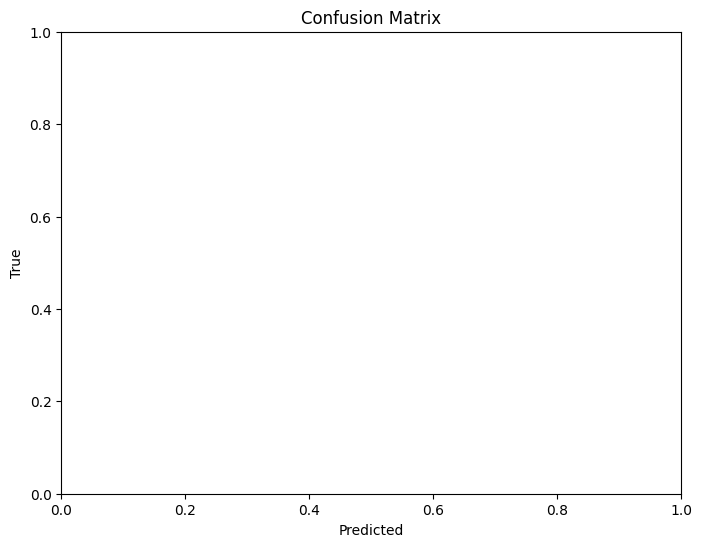

In [98]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



y_val_pred = model.predict(X_val)
acc = (y_val_pred == y_val).mean()
print("Test accuracy =", acc)

cm = confusion_matrix(y_val, y_val_pred)
bal_acc = balanced_accuracy(y_val, y_val_pred)
rec = recall_per_class(cm)
print(classification_report(y_val, y_val_pred))
print("Balanced acc :", bal_acc)
print("Recall par classe :", rec)
print("Recall moyen :", rec.mean())
plt.figure(figsize=(8, 6))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()





In [99]:
model_pkg = {
    'model': model, 
    'scaler': scaler, 
    'train_min': train_min,
    'train_max':train_max,
    'train_mean': train_mean,
    'train_std': train_std
}

pickle.dump(model_pkg, open("model_perceptron.pkl", "wb"))


In [100]:


# --------------------------
# 1. Charger le modèle entraîné
# --------------------------
model_pkg_pred = pickle.load(open("model_perceptron.pkl", "rb"))
model= model_pkg_pred['model']
scaler = model_pkg_pred['scaler']
train_min = model_pkg_pred['train_min']
train_max = model_pkg_pred['train_max']
train_mean = model_pkg_pred['train_mean']
train_std = model_pkg_pred['train_std']

# --------------------------
# 2. Charger le test_data.pkl
# --------------------------
with open("ift-3395-6390-kaggle-2-competition-fall-2025/test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

X_test_imgs = test_data["images"].astype(np.float32)

X_test_imgs = (X_test_imgs - train_min) / (train_max - train_min + 1e-6)
#X_test_imgs = (X_test_imgs - train_mean) / (train_std + 1e-6)

# --------------------------
# 4. Normaliser avec les stats du train
# --------------------------
fft_mag_test = fft_features(X_test_imgs)
X_fft_test = np.array([radial_profile(img) for img in fft_mag_test], dtype=np.float32)
X_stats_test = np.array([extract_simple_stats(img) for img in X_test_imgs], dtype=np.float32)
X_color_test = np.array([extract_channel_stats(img) for img in X_test_imgs], dtype=np.float32)
X_hsv_test = np.array([extract_hsv_stats(img) for img in X_test_imgs], dtype=np.float32)
X_sobel_test = np.array([extract_sobel_features(img) for img in X_test_imgs], dtype=np.float32)
X_test = np.hstack([X_fft_test, X_stats_test, X_color_test])

X_test = scaler.transform(X_test)

# --------------------------
# 5. Prédire
# --------------------------

y_pred = model.predict(X_test).astype(int)

# --------------------------
# 6. Générer le CSV Kaggle
# --------------------------
df = pd.DataFrame({
    "ID": np.arange(1, len(y_pred)+1),
    "Label": y_pred
})

df.to_csv("IFT3395_YAPS_MCS_V100.csv", index=False)

print("Fichier 'submission.csv' généré !")

#print(df.head())



Fichier 'submission.csv' généré !


In [102]:

df1 = pd.read_csv("IFT3395_YAPS_MCS_V100.csv")
#df2 = pd.read_csv("IFT3396_YAPS_MCS_V62.csv")

df2 = pd.read_csv("IFT3395_YAPS_MCS_V14_ref.csv")

comparison = df1.compare(df2)
print(comparison)
print("Nombre de différences :", len(comparison))


    Label      
     self other
1     0.0   3.0
6     0.0   4.0
10    0.0   4.0
13    0.0   3.0
17    0.0   3.0
..    ...   ...
386   0.0   2.0
388   0.0   3.0
391   0.0   3.0
393   0.0   4.0
397   0.0   1.0

[208 rows x 2 columns]
Nombre de différences : 208
